Using device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB
=== CycleGAN Training ===
Initializing CycleGAN...


100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.9MB/s]


Starting training for 2 epochs...


Epoch 1/2 - Generator Loss: 0.3471, Discriminator Loss: 0.1355


Epoch 2/2 - Generator Loss: 0.2288, Discriminator Loss: 0.1278
CycleGAN training completed!
Generating final CycleGAN samples...


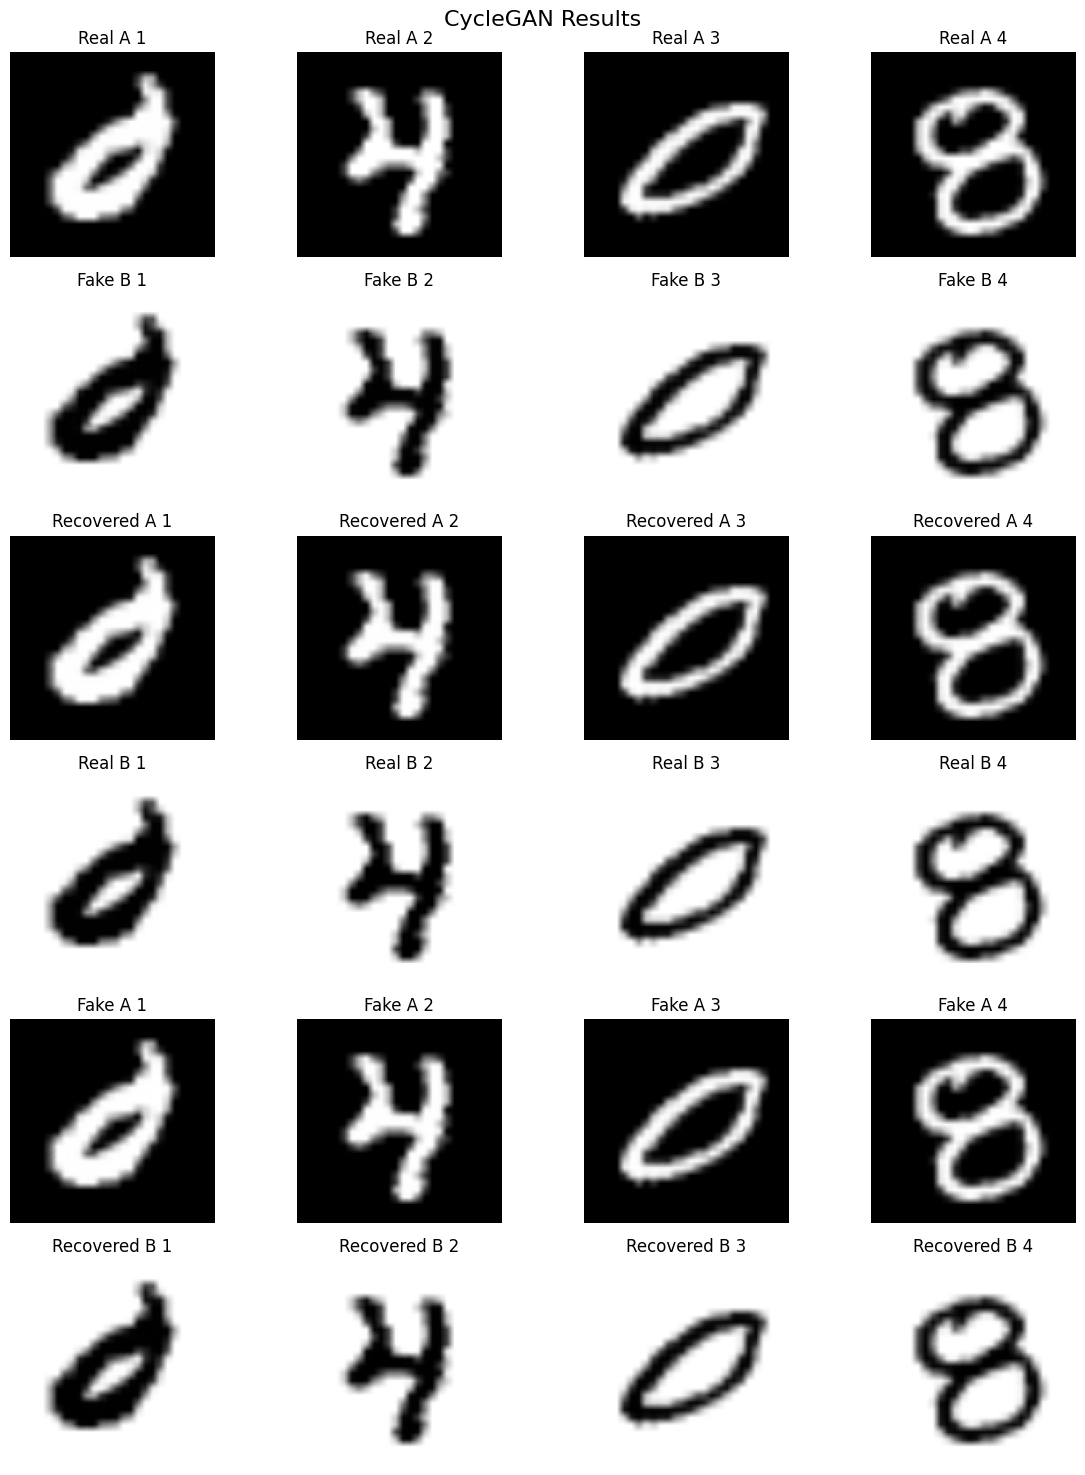

Saving models...
Models saved successfully!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

class ResidualBlock(nn.Module):
    """Residual block for CycleGAN generator"""
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    """CycleGAN Generator with ResNet architecture"""
    def __init__(self, input_nc=3, output_nc=3, n_residual_blocks=6):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    """PatchGAN Discriminator"""
    def __init__(self, input_nc=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(input_nc, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

class ImageBuffer:
    """Image buffer to store previously generated images"""
    def __init__(self, buffer_size=50):
        self.buffer_size = buffer_size
        self.buffer = []

    def push_and_pop(self, images):
        if self.buffer_size == 0:
            return images

        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if len(self.buffer) < self.buffer_size:
                self.buffer.append(image)
                return_images.append(image)
            else:
                if np.random.uniform(0, 1) > 0.5:
                    i = np.random.randint(0, self.buffer_size - 1)
                    return_images.append(self.buffer[i].clone())
                    self.buffer[i] = image
                else:
                    return_images.append(image)
        return torch.cat(return_images, 0)

def prepare_data(batch_size=8, image_size=128):
    """Prepare MNIST data for CycleGAN"""
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.Grayscale(num_output_channels=3),  # Convert to RGB
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [-1, 1]
    ])

    dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    # Create domain B by inverting domain A (simple style transfer)
    def create_domain_b(data_a):
        return -data_a  # Invert the images

    return dataloader, create_domain_b

def weights_init_normal(m):
    """Initialize network weights safely"""
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        if hasattr(m, "weight") and m.weight is not None:
            torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1 or classname.find("InstanceNorm2d") != -1:
        if hasattr(m, "weight") and m.weight is not None:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)


def train_cyclegan(epochs=50, batch_size=8, lr=0.0002, lambda_cyc=10.0, lambda_id=0.1):
    """Train CycleGAN"""
    print("Initializing CycleGAN...")

    # Initialize generators and discriminators
    G_AB = Generator().to(device)  # A to B
    G_BA = Generator().to(device)  # B to A
    D_A = Discriminator().to(device)
    D_B = Discriminator().to(device)

    # Initialize weights
    G_AB.apply(weights_init_normal)
    G_BA.apply(weights_init_normal)
    D_A.apply(weights_init_normal)
    D_B.apply(weights_init_normal)

    # Loss functions
    criterion_GAN = nn.MSELoss()
    criterion_cycle = nn.L1Loss()
    criterion_identity = nn.L1Loss()

    # Optimizers
    optimizer_G = optim.Adam(
        list(G_AB.parameters()) + list(G_BA.parameters()),
        lr=lr, betas=(0.5, 0.999)
    )
    optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))

    # Learning rate schedulers
    scheduler_G = optim.lr_scheduler.LambdaLR(
        optimizer_G, lr_lambda=lambda epoch: 1.0 - max(0, epoch - epochs // 2) / (epochs // 2)
    )
    scheduler_D_A = optim.lr_scheduler.LambdaLR(
        optimizer_D_A, lr_lambda=lambda epoch: 1.0 - max(0, epoch - epochs // 2) / (epochs // 2)
    )
    scheduler_D_B = optim.lr_scheduler.LambdaLR(
        optimizer_D_B, lr_lambda=lambda epoch: 1.0 - max(0, epoch - epochs // 2) / (epochs // 2)
    )

    # Image buffers
    fake_A_buffer = ImageBuffer()
    fake_B_buffer = ImageBuffer()

    # Data
    dataloader, create_domain_b = prepare_data(batch_size)

    print(f"Starting training for {epochs} epochs...")

    for epoch in range(epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        num_batches = 0

        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)

        for batch_idx, (real_A, _) in enumerate(progress_bar):
            batch_size_current = real_A.size(0)

            # Create domain B data
            real_A = real_A.to(device, non_blocking=True)
            real_B = create_domain_b(real_A).to(device, non_blocking=True)

            # Real and fake labels
            valid = torch.ones((batch_size_current, 1, 8, 8), requires_grad=False, device=device)
            fake = torch.zeros((batch_size_current, 1, 8, 8), requires_grad=False, device=device)

            # Train Generators
            optimizer_G.zero_grad()

            # Identity loss
            loss_id_A = criterion_identity(G_BA(real_A), real_A)
            loss_id_B = criterion_identity(G_AB(real_B), real_B)
            loss_identity = (loss_id_A + loss_id_B) / 2

            # GAN loss
            fake_B = G_AB(real_A)
            fake_A = G_BA(real_B)

            loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
            loss_GAN_BA = criterion_GAN(D_A(fake_A), fake) # Should be fake for GAN loss on fake images
            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

            # Cycle loss
            recovered_A = G_BA(fake_B)
            recovered_B = G_AB(fake_A)

            loss_cycle_A = criterion_cycle(recovered_A, real_A)
            loss_cycle_B = criterion_cycle(recovered_B, real_B)
            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            # Total generator loss
            loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity

            loss_G.backward()
            optimizer_G.step()

            # Train Discriminator A
            optimizer_D_A.zero_grad()

            pred_real = D_A(real_A)
            loss_D_A_real = criterion_GAN(pred_real, valid)

            fake_A_buffered = fake_A_buffer.push_and_pop(fake_A)
            pred_fake = D_A(fake_A_buffered.detach())
            loss_D_A_fake = criterion_GAN(pred_fake, fake)

            loss_D_A = (loss_D_A_real + loss_D_A_fake) / 2

            loss_D_A.backward()
            optimizer_D_A.step()

            # Train Discriminator B
            optimizer_D_B.zero_grad()

            pred_real = D_B(real_B)
            loss_D_B_real = criterion_GAN(pred_real, valid)

            fake_B_buffered = fake_B_buffer.push_and_pop(fake_B)
            pred_fake = D_B(fake_B_buffered.detach())
            loss_D_B_fake = criterion_GAN(pred_fake, fake)

            loss_D_B = (loss_D_B_real + loss_D_B_fake) / 2

            loss_D_B.backward()
            optimizer_D_B.step()

            # Accumulate losses
            epoch_g_loss += loss_G.item()
            epoch_d_loss += (loss_D_A.item() + loss_D_B.item()) / 2
            num_batches += 1

            # Update progress bar
            progress_bar.set_postfix({
                'G_Loss': f'{loss_G.item():.4f}',
                'D_Loss': f'{(loss_D_A.item() + loss_D_B.item()) / 2:.4f}'
            })

            # Generate samples periodically
            if batch_idx == 0 and (epoch + 1) % 10 == 0:
                generate_cyclegan_samples(G_AB, G_BA, real_A[:4], real_B[:4], epoch + 1)

        # Update learning rates
        scheduler_G.step()
        scheduler_D_A.step()
        scheduler_D_B.step()

        # Print epoch statistics
        if num_batches > 0:
            avg_g_loss = epoch_g_loss / num_batches
            avg_d_loss = epoch_d_loss / num_batches
            print(f"Epoch {epoch+1}/{epochs} - Generator Loss: {avg_g_loss:.4f}, Discriminator Loss: {avg_d_loss:.4f}")

    print("CycleGAN training completed!")
    return G_AB, G_BA, D_A, D_B

def generate_cyclegan_samples(G_AB, G_BA, real_A, real_B, epoch=None):
    """Generate and display CycleGAN samples"""
    G_AB.eval()
    G_BA.eval()

    with torch.no_grad():
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        recovered_A = G_BA(fake_B)
        recovered_B = G_AB(fake_A)

    # Convert tensors to numpy for visualization
    def tensor_to_image(tensor):
        img = tensor.cpu().detach().numpy()
        img = (img + 1) / 2  # [-1, 1] to [0, 1]
        img = np.transpose(img, (0, 2, 3, 1))
        return img[:, :, :, 0]  # Use first channel for grayscale

    real_A_np = tensor_to_image(real_A)
    fake_B_np = tensor_to_image(fake_B)
    recovered_A_np = tensor_to_image(recovered_A)
    real_B_np = tensor_to_image(real_B)
    fake_A_np = tensor_to_image(fake_A)
    recovered_B_np = tensor_to_image(recovered_B)

    # Plot results
    fig, axes = plt.subplots(6, 4, figsize=(12, 15))
    titles = ['Real A', 'Fake B', 'Recovered A', 'Real B', 'Fake A', 'Recovered B']
    images = [real_A_np, fake_B_np, recovered_A_np, real_B_np, fake_A_np, recovered_B_np]

    for row, (title, img_batch) in enumerate(zip(titles, images)):
        for col in range(4):
            axes[row, col].imshow(img_batch[col], cmap='gray')
            axes[row, col].set_title(f'{title} {col+1}')
            axes[row, col].axis('off')

    title = 'CycleGAN Results'
    if epoch:
        title += f' - Epoch {epoch}'
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    G_AB.train()
    G_BA.train()

# Run CycleGAN training
if __name__ == "__main__":
    print("=== CycleGAN Training ===")
    G_AB, G_BA, D_A, D_B = train_cyclegan(epochs=2, batch_size=8, lr=0.0002)

    # Generate final samples
    print("Generating final CycleGAN samples...")
    dataloader, create_domain_b = prepare_data(batch_size=4)
    for real_A, _ in dataloader:
        real_A = real_A.to(device)
        real_B = create_domain_b(real_A).to(device)
        generate_cyclegan_samples(G_AB, G_BA, real_A, real_B)
        break

    # Save models
    print("Saving models...")
    torch.save(G_AB.state_dict(), 'cyclegan_G_AB.pth')
    torch.save(G_BA.state_dict(), 'cyclegan_G_BA.pth')
    torch.save(D_A.state_dict(), 'cyclegan_D_A.pth')
    torch.save(D_B.state_dict(), 'cyclegan_D_B.pth')
    print("Models saved successfully!")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
import json

# Enable eager execution
tf.config.run_functions_eagerly(True)

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)

# Load and preprocess MNIST dataset
print("Loading MNIST dataset...")
(x_train, _), (_, _) = keras.datasets.mnist.load_data()

# Normalize to [-1, 1] range and reshape
def preprocess_data(data, target_size=(32, 32)):
    data = data.astype('float32')
    data = (data - 127.5) / 127.5  # Normalize to [-1, 1]

    # Resize to target size
    data_resized = []
    for img in data:
        img_resized = tf.image.resize(img[..., np.newaxis], target_size)
        data_resized.append(img_resized)

    return np.array(data_resized)

# Preprocess dataset
mnist_images = preprocess_data(x_train[:50000])  # Use 50,000 images
print(f"MNIST shape: {mnist_images.shape}")
print(f"Data range: [{mnist_images.min():.2f}, {mnist_images.max():.2f}]")

# StyleGAN Components
class PixelNormalization(layers.Layer):
    """Pixel normalization layer"""
    def __init__(self, epsilon=1e-8, **kwargs):
        super(PixelNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def call(self, inputs):
        return inputs / tf.sqrt(tf.reduce_mean(inputs**2, axis=-1, keepdims=True) + self.epsilon)

class MiniBatchStdDev(layers.Layer):
    """Mini-batch standard deviation layer"""
    def __init__(self, group_size=4, epsilon=1e-8, **kwargs):
        super(MiniBatchStdDev, self).__init__(**kwargs)
        self.group_size = group_size
        self.epsilon = epsilon

    def call(self, inputs):
        group_size = tf.minimum(self.group_size, tf.shape(inputs)[0])

        # Split into groups
        shape = tf.shape(inputs)
        grouped = tf.reshape(inputs, [group_size, -1, shape[1], shape[2], shape[3]])

        # Calculate standard deviation
        stddev = tf.math.reduce_std(grouped, axis=0)
        stddev = tf.reduce_mean(stddev, axis=[1, 2, 3], keepdims=True)
        stddev = tf.tile(stddev, [group_size, shape[1], shape[2], 1])

        return tf.concat([inputs, stddev], axis=-1)

class WeightedSum(layers.Layer):
    """Weighted sum of two layers"""
    def __init__(self, alpha=0.0, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)
        self.alpha = tf.Variable(alpha, trainable=False, dtype=tf.float32)

    def call(self, inputs):
        return (1.0 - self.alpha) * inputs[0] + self.alpha * inputs[1]

class AdaIN(layers.Layer):
    """Adaptive Instance Normalization"""
    def __init__(self, **kwargs):
        super(AdaIN, self).__init__(**kwargs)
        self.instance_norm = layers.LayerNormalization(axis=[1, 2], epsilon=1e-8)

    def call(self, inputs):
        x, w = inputs
        # Instance normalization
        x = self.instance_norm(x)

        # Reshape w to match x's channel dimension for broadcasting
        shape = tf.shape(x)
        w = tf.reshape(w, [-1, 1, 1, shape[-1] * 2])

        # Apply style (scale and bias from w)
        style_scale = w[:, :, :, :shape[-1]]
        style_bias = w[:, :, :, shape[-1]:]

        return style_scale * x + style_bias

class ConstantInput(layers.Layer):
    """Layer that outputs a constant tensor with batch size from input"""
    def __init__(self, shape, **kwargs):
        super(ConstantInput, self).__init__(**kwargs)
        self.shape = shape

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return tf.zeros(shape=[batch_size] + list(self.shape), dtype=tf.float32)

# Mapping Network
def build_mapping_network(latent_dim=512, hidden_dim=512, num_layers=8):
    """Build the mapping network"""
    model = keras.Sequential()
    model.add(layers.Input(shape=(latent_dim,)))

    for i in range(num_layers):
        model.add(layers.Dense(hidden_dim, activation='relu'))
        model.add(PixelNormalization())

    # Output style vector
    model.add(layers.Dense(latent_dim))

    return model

# Synthesis Network Blocks
def build_synthesis_block(filters, style_dim, input_shape=None, is_base=False):
    """Build a synthesis block"""
    # Inputs: latent vector for base block, feature map for subsequent blocks
    inputs = layers.Input(shape=input_shape) if input_shape else layers.Input(shape=(style_dim,))
    style_input = layers.Input(shape=(style_dim,))

    # Initial input
    if is_base:
        # Use the ConstantInput layer for the base block
        x = ConstantInput(shape=(4, 4, filters))(inputs)
    else:
        x = layers.UpSampling2D()(inputs)

    # Project style vector to 2 * filters for scale and bias
    style_projected = layers.Dense(filters * 2)(style_input)

    # First convolution with AdaIN
    x = layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = AdaIN()([x, style_projected])
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Second convolution with AdaIN
    x = layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = AdaIN()([x, style_projected])
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Noise injection
    noise = layers.Lambda(lambda x: tf.random.normal(tf.shape(x)[:-1] + [1]))(x)
    noise_weight = layers.Dense(filters)(style_input)
    noise_weight = layers.Reshape((1, 1, filters))(noise_weight)
    x = layers.Add()([x, noise * noise_weight])


    return keras.Model([inputs, style_input], x) if input_shape else keras.Model(style_input, x)

# Discriminator Blocks
def build_discriminator_block(filters, input_shape=None, is_final=False):
    """Build a discriminator block"""
    inputs = layers.Input(shape=input_shape) if input_shape else None

    if is_final:
        x = MiniBatchStdDev()(inputs)
        x = layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Flatten()(x)
        x = layers.Dense(1)(x)
    else:
        x = layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(inputs)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.AveragePooling2D()(x)

    return keras.Model(inputs, x)

# Build StyleGAN Generator
def build_stylegan_generator(latent_dim=512, style_dim=512, base_filters=512):
    """Build StyleGAN generator"""
    # Mapping network
    mapping_network = build_mapping_network(latent_dim, style_dim)

    # Base synthesis block (4x4)
    # Note: The base block now takes the latent input directly
    base_block = build_synthesis_block(base_filters, style_dim, is_base=True)

    # Higher resolution blocks
    blocks = []
    filters = base_filters

    # Resolution progression: 4x4 -> 8x8 -> 16x16 -> 32x32
    resolutions = [8, 16, 32]
    prev_filters = base_filters # Keep track of filters from the previous block

    for i, res in enumerate(resolutions):
        filters = max(filters // 2, 64)  # Reduce filters for the current block
        # The input shape to the synthesis block is the output shape of the previous block
        block = build_synthesis_block(filters, style_dim, input_shape=(res//2, res//2, prev_filters))
        blocks.append(block)
        prev_filters = filters # Update previous filters for the next iteration


    # RGB converters for each resolution
    rgb_converters = []
    current_filters = base_filters # Reset filters for RGB converters
    for i, res in enumerate([4, 8, 16, 32]):
        rgb_converters.append(
            keras.Sequential([
                layers.Conv2D(1, 1, padding='same', activation='tanh',
                             kernel_initializer='he_normal')
            ])
        )
        current_filters = max(current_filters // 2, 64) # Update filters for the next RGB converter


    # Build the generator model
    latent_input = layers.Input(shape=(latent_dim,))
    style_vector = mapping_network(latent_input)

    # Base block
    # The base block now takes the latent_input
    x = base_block([latent_input, style_vector])
    rgb = rgb_converters[0](x)

    # Progressive blocks
    for i, block in enumerate(blocks):
        x = block([x, style_vector])
        rgb_up = layers.UpSampling2D()(rgb)
        rgb_new = rgb_converters[i+1](x)

        # Weighted sum for smooth transition
        if i == len(blocks) - 1:  # Final block
            alpha = WeightedSum().alpha
            rgb = WeightedSum(alpha=alpha)([rgb_up, rgb_new])
        else:
            alpha = WeightedSum().alpha
            rgb = WeightedSum(alpha=alpha)([rgb_up, rgb_new])


    return keras.Model(latent_input, rgb, name='generator')

# Build StyleGAN Discriminator
def build_stylegan_discriminator(base_filters=64):
    """Build StyleGAN discriminator"""
    # Input
    inputs = layers.Input(shape=(32, 32, 1))

    # From RGB
    x = layers.Conv2D(base_filters, 1, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Discriminator blocks (progressive)
    blocks = []
    filters = base_filters

    # Resolution progression: 32x32 -> 16x16 -> 8x8 -> 4x4
    resolutions = [16, 8, 4]
    prev_filters = base_filters # Keep track of filters from the previous block

    for i, res in enumerate(resolutions):
        filters = min(filters * 2, 512)  # Increase filters for the current block
        # The input shape to the discriminator block is the output shape of the previous block
        block = build_discriminator_block(filters, input_shape=(res*2, res*2, prev_filters))
        blocks.append(block)
        prev_filters = filters # Update previous filters for the next iteration

    # Apply blocks in reverse order
    for block in blocks:
        x = block(x)

    # Final block
    x = build_discriminator_block(filters, input_shape=(4, 4, filters), is_final=True)(x)

    return keras.Model(inputs, x, name='discriminator')

# Build models
print("Building StyleGAN models...")
latent_dim = 512
style_dim = 512

generator = build_stylegan_generator(latent_dim, style_dim)
discriminator = build_stylegan_discriminator()

print("Generator Summary:")
generator.summary()
print("\nDiscriminator Summary:")
discriminator.summary()

# StyleGAN Training Class
class StyleGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim=512,
                 gradient_penalty_weight=10, drift_weight=0.001):
        super(StyleGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.gradient_penalty_weight = gradient_penalty_weight
        self.drift_weight = drift_weight

        # Optimizers
        self.g_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.99)
        self.d_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.99)

        # Loss trackers
        self.g_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.d_loss_tracker = keras.metrics.Mean(name="d_loss")
        self.real_score_tracker = keras.metrics.Mean(name="real_score")
        self.fake_score_tracker = keras.metrics.Mean(name="fake_score")

    @property
    def metrics(self):
        return [self.g_loss_tracker, self.d_loss_tracker,
                self.real_score_tracker, self.fake_score_tracker]

    def gradient_penalty(self, real_images, fake_images):
        """Compute gradient penalty for WGAN-GP"""
        batch_size = tf.shape(real_images)[0]
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        interpolated = alpha * real_images + (1 - alpha) * fake_images

        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        gradients = tape.gradient(pred, interpolated)
        gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
        penalty = tf.reduce_mean(tf.square(gradients_norm - 1.0))

        return penalty

    def train_step(self, real_images):
        # Train discriminator
        batch_size = tf.shape(real_images)[0]

        # Generate random latents
        random_latents = tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape() as d_tape:
            # Generate fake images
            fake_images = self.generator(random_latents, training=True)

            # Discriminator outputs
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(fake_images, training=True)

            # Discriminator loss
            d_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

            # Gradient penalty
            gp = self.gradient_penalty(real_images, fake_images)
            d_loss += self.gradient_penalty_weight * gp

            # Drift penalty
            d_loss += self.drift_weight * tf.reduce_mean(real_output ** 2)

        # Apply gradients to discriminator
        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(
            zip(d_gradients, self.discriminator.trainable_variables)
        )

        # Train generator
        with tf.GradientTape() as g_tape:
            # Generate fake images
            fake_images = self.generator(random_latents, training=True)

            # Discriminator outputs
            fake_output = self.discriminator(fake_images, training=True)

            # Generator loss
            g_loss = -tf.reduce_mean(fake_output)

        # Apply gradients to generator
        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(g_gradients, self.generator.trainable_variables)
        )

        # Update metrics
        self.g_loss_tracker.update_state(g_loss)
        self.d_loss_tracker.update_state(d_loss)
        self.real_score_tracker.update_state(tf.reduce_mean(real_output))
        self.fake_score_tracker.update_state(tf.reduce_mean(fake_output))

        return {
            "g_loss": self.g_loss_tracker.result(),
            "d_loss": self.d_loss_tracker.result(),
            "real_score": self.real_score_tracker.result(),
            "fake_score": self.fake_score_tracker.result(),
        }

# Training utilities
def generate_and_save_images(model, epoch, test_input, save_dir='stylegan_images'):
    """Generate and save sample images"""
    os.makedirs(save_dir, exist_ok=True)

    predictions = model.generator(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}', fontsize=16)
    plt.savefig(f'{save_dir}/epoch_{epoch}.png', dpi=300, bbox_inches='tight')
    plt.close()

def save_checkpoint(model, epoch, save_dir='stylegan_checkpoints'):
    """Save model checkpoint"""
    os.makedirs(save_dir, exist_ok=True)

    model.generator.save(f'{save_dir}/generator_epoch_{epoch}.h5')
    model.discriminator.save(f'{save_dir}/discriminator_epoch_{epoch}.h5')

    print(f"Checkpoint saved for epoch {epoch}")

def create_training_report(losses_dict, epochs):
    """Create training report with visualizations"""
    os.makedirs('stylegan_results', exist_ok=True)

    # Plot losses
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(losses_dict['g_loss'], label='Generator Loss')
    plt.title('Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.plot(losses_dict['d_loss'], label='Discriminator Loss', color='orange')
    plt.title('Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.plot(losses_dict['real_score'], label='Real Score')
    plt.plot(losses_dict['fake_score'], label='Fake Score')
    plt.title('Real vs Fake Scores')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    plt.plot(np.array(losses_dict['real_score']) - np.array(losses_dict['fake_score']),
             label='Score Difference', color='purple')
    plt.title('Real - Fake Score Difference')
    plt.xlabel('Epoch')
    plt.ylabel('Difference')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('stylegan_results/training_report.png', dpi=300, bbox_inches='tight')
    plt.close()

    print("Training report saved to stylegan_results/training_report.png")

# Training function
def train_stylegan(model, dataset, epochs=100, batch_size=32, save_freq=10):
    """Train StyleGAN model"""
    # Create directories
    os.makedirs('stylegan_images', exist_ok=True)
    os.makedirs('stylegan_checkpoints', exist_ok=True)
    os.makedirs('stylegan_results', exist_ok=True)

    # Fixed latent vectors for consistent image generation
    fixed_latents = tf.random.normal(shape=(16, model.latent_dim))

    # Initialize loss tracking
    losses_history = {
        'g_loss': [],
        'd_loss': [],
        'real_score': [],
        'fake_score': []
    }

    # Create dataset
    train_dataset = tf.data.Dataset.from_tensor_slices(dataset)
    train_dataset = train_dataset.shuffle(10000).batch(batch_size)

    print(f"Training StyleGAN for {epochs} epochs with batch size {batch_size}")

    for epoch in range(epochs):
        epoch_losses = {key: [] for key in losses_history.keys()}

        for batch in train_dataset:
            losses = model.train_step(batch)

            for key in losses_history.keys():
                epoch_losses[key].append(losses[key].numpy())

        # Calculate epoch averages
        for key in losses_history.keys():
            losses_history[key].append(np.mean(epoch_losses[key]))

        # Print progress
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Generator Loss: {losses_history['g_loss'][-1]:.4f}")
        print(f"Discriminator Loss: {losses_history['d_loss'][-1]:.4f}")
        print(f"Real Score: {losses_history['real_score'][-1]:.4f}")
        print(f"Fake Score: {losses_history['fake_score'][-1]:.4f}")
        print("-" * 50)

        # Generate sample images
        if (epoch + 1) % save_freq == 0:
            generate_and_save_images(model, epoch+1, fixed_latents)
            print(f"Sample images saved for epoch {epoch+1}")

            # Save checkpoint
            save_checkpoint(model, epoch+1)

    # Save final models
    model.generator.save('stylegan_results/final_generator.h5')
    model.discriminator.save('stylegan_results/final_discriminator.h5')

    # Create training report
    create_training_report(losses_history, epochs)

    return losses_history

# Initialize StyleGAN
print("Initializing StyleGAN...")
stylegan = StyleGAN(generator, discriminator, latent_dim)

print("Starting StyleGAN training...")
try:
    # Train StyleGAN
    losses_history = train_stylegan(
        stylegan, mnist_images,
        epochs=100,
        batch_size=32,
        save_freq=10
    )

    # Generate final samples
    print("Generating final samples...")
    test_latents = tf.random.normal(shape=(64, latent_dim))
    generated_images = stylegan.generator(test_latents, training=False)

    # Create a grid of generated images
    plt.figure(figsize=(10, 10))
    for i in range(64):
        plt.subplot(8, 8, i+1)
        plt.imshow(generated_images[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')

    plt.suptitle('Final Generated MNIST Digits', fontsize=16)
    plt.savefig('stylegan_results/final_generated.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("=" * 60)
    print("STYLEGAN TRAINING COMPLETED SUCCESSFULLY!")
    print("=" * 60)
    print("Files and directories created:")
    print("📁 stylegan_images/       - Generated images during training")
    print("📁 stylegan_checkpoints/  - Model checkpoints")
    print("📁 stylegan_results/      - Final models and results")
    print("📄 training_report.png    - Training visualization")
    print("📄 final_generated.png    - Final generated samples")
    print("=" * 60)

except Exception as e:
    print(f"Training failed with error: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "="*60)
print("STYLEGAN USAGE EXAMPLES:")
print("="*60)
print("# To generate new MNIST digits:")
print("# generator = keras.models.load_model('stylegan_results/final_generator.h5',")
print("#                             custom_objects={'PixelNormalization': PixelNormalization,")
print("#                                            'AdaIN': AdaIN})")
print("# latent_vector = tf.random.normal(shape=(1, 512))")
print("# generated_digit = generator(latent_vector, training=False)")
print("="*60)

TensorFlow version: 2.19.0
Loading MNIST dataset...
